In [ ]:
# Imports
from src.json_utils import read_jsonl
from src.config import DATA_DIR
import pandas as pd
import os

In [30]:
data = read_jsonl('../data/dkpol_tweets.jsonl')

Reading ../data/dkpol_tweets.jsonl


AttributeError: 'list' object has no attribute 'info'

In [29]:
df = pd.DataFrame([i['created_at'] for i in data], columns=['timestamp'])
df.timestamp = pd.to_datetime(df.timestamp)
df.info()
df[['timestamp', ]].groupby(df.timestamp.dt.to_period("M")).agg('count').plot(kind='bar')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70170 entries, 0 to 70169
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  70170 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 548.3 KB


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [62]:
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text']].groupby(df.created_at.dt.to_period("M")).head(350)

<AxesSubplot:xlabel='created_at'>

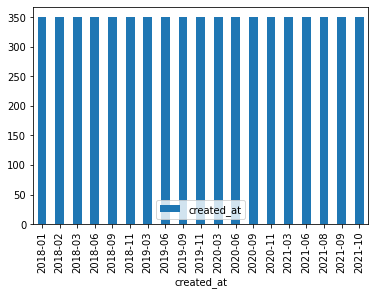

In [63]:
sub[['created_at']].groupby(df.created_at.dt.to_period("M")).agg('count').plot(kind='bar')

,timestamp
0,2021-10-19 15:56:57+00:00
1,2021-10-19 15:54:31+00:00
2,2021-10-19 15:54:31+00:00
3,2021-10-19 15:53:58+00:00
4,2021-10-19 15:50:50+00:00
...,...
197,2021-10-19 11:45:16+00:00
198,2021-10-19 11:43:43+00:00
199,2021-10-19 11:43:39+00:00
17341,2021-09-30 23:43:08+00:00


In [17]:
sub.head()

0   2021-10-19 15:56:57+00:00
1   2021-10-19 15:54:31+00:00
2   2021-10-19 15:54:31+00:00
3   2021-10-19 15:53:58+00:00
4   2021-10-19 15:50:50+00:00
Name: timestamp, dtype: datetime64[ns, UTC]